In [7]:
import numpy as np
import tqdm
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
from gym import spaces
import gym

from tqdm import tqdm_notebook

import base64, io

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def show_video_of_model(policy, env_name):
    env = gym.make(env_name, render_mode = "human")
    state = env.reset()
    done = False
    G = 0
    for t in range(10000):
        action, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        G += reward
        state = next_state
        if done:
            break
    env.close()

In [10]:
class ActorNet(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(ActorNet, self).__init__()

        """ CODE HERE:
                Implement the neural network here
        """
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        """ CODE HERE:
                Implement the forward propagation
        """
        x = F.relu(self.fc1(x))
        y = F.softmax(self.fc2(x), dim=1)
        return y
    
    def act(self, state):
        state_tensor = torch.from_numpy(state.copy()).float().unsqueeze(0).to(device)
        probs = self.forward(state_tensor)
        # makes a prob distribution from the given probabilities so that we can 
        # sample action from it
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [11]:
class CriticNet(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CriticNet, self).__init__()

        """ CODE HERE:
                Implement the neural network here
        """
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, output_dims)

    def forward(self, state):
        """ CODE HERE:
                Implement the forward propagation
        """
        x = torch.from_numpy(state).float().unsqueeze(0).to(device)
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y

In [12]:
my_env = gym.make('CartPole-v1')


episode_num = 10000
learning_rate_actor=  0.0001
learning_rate_critic= 0.001
solved_score = 300
gamma = 0.99

action_num = my_env.action_space.n

hidden_dim = 128
observation_dim = my_env.observation_space.shape[0]

actor = ActorNet(observation_dim, hidden_dim, action_num).to(device)

critic = CriticNet(observation_dim, hidden_dim, 1).to(device) 

optimizer_actor = torch.optim.Adam(actor.parameters(), lr=learning_rate_actor)
optimizer_critic = torch.optim.Adam(critic.parameters(), lr=learning_rate_critic)

In [16]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 100)

for episode in range(episode_num):
    
    state = my_env.reset()
    done = False
    I = 1
    score = 0
    
    while not done:
        action , log_act_probs = actor.act(state)
        next_state, reward, done, _ = my_env.step(action)
        score += reward
        if done:
            v_next_state = torch.tensor([0]).float().unsqueeze(0).to(device)
        else:
            v_next_state = critic.forward(next_state)
        v_state = critic.forward(state)
         
        # delta or the advantage is estimating how good the actions leading to the next sate and reward will be
        # we are trying to increase our advantage and trying to teach the critic to resemble this advantage for the state
        with torch.no_grad():
            delta = reward + gamma * v_next_state.item() - v_state.item()
        # (to implement like in sutton's book, negative because you want ascent not descent)
        value_loss = -delta*v_state
#         value_loss = F.mse_loss(reward + gamma * v_next_state, v_state)
        # the negative of this loss is taken because we want to increase this behaviour via stochastic gradient ascent
        # that is because we are trying to maximise the probabilities of actions that lead to higher rewards
        # Also we are scaling the gradient of action probs using the advantage and we are able to pass in .backward() because 
        # the agvantage is not parametrized by the policy nets parameters and thus will not affect the gradient of policy loss
        policy_loss = -log_act_probs*delta
        policy_loss *= I
        
        optimizer_critic.zero_grad()
        optimizer_actor.zero_grad()
        (value_loss + policy_loss).backward()
        optimizer_critic.step()
        optimizer_actor.step()
        
        I *= gamma
        state = next_state
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)
    #early stopping if we meet solved score goal
    if episode%50==0:
        print("Mean score of past 100 episodes" ,np.array(recent_scores).mean())
    if np.array(recent_scores).mean() >= solved_score:
        break

Mean score of past 100 episodes 13.0
Mean score of past 100 episodes 20.686274509803923
Mean score of past 100 episodes 20.33
Mean score of past 100 episodes 21.83
Mean score of past 100 episodes 29.21
Mean score of past 100 episodes 43.18
Mean score of past 100 episodes 51.27
Mean score of past 100 episodes 62.26
Mean score of past 100 episodes 110.2
Mean score of past 100 episodes 185.52
Mean score of past 100 episodes 208.2
Mean score of past 100 episodes 256.86


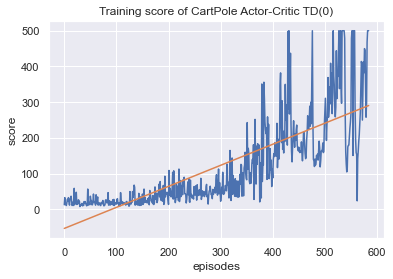

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole Actor-Critic TD(0)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [19]:
show_video_of_model(actor, 'CartPole-v1')